<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [224]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Markdown, display
import sys
sys.path.append('/home/jfiorote/ga_error_sources_framework')
from models.ProteinSystemModel  import ProteinSystemModel
from models.GAModel  import GAModel
from decimal import Decimal
from scipy.integrate import quad
from scipy.special import binom

In [225]:
sns.set_theme()
sns.set_style("darkgrid")
sns.color_palette("deep")
sns.despine(left=True)

## Model Functions


In [226]:
def get_alpha(m, i_0, i_nat):
    
    return math.log(i_nat - i_0 + 1) / m


def get_beta(m, sigma2_0):
    
    return math.log(sigma2_0 + 1) / m


def expec_n(m, i_0, i_nat):

    alpha = get_alpha(m, i_0, i_nat)
    return [i_0 + (math.exp(alpha * n) - 1) for n in range(m + 1)]


def sigma2_n(m, sigma2_0):
    
    beta = get_beta(m, sigma2_0)
    
    sigmas2_n = []
    for n in range(m + 1):
        sigma2 = sigma2_0 - (math.exp(beta * n) - 1) 
        if sigma2 > 0: 
            sigmas2_n.append(sigma2)
        else:
            sigmas2_n.append(sigmas2_n[n - 1]) # get last valid sigma2
            
    return sigmas2_n


def gap_n(m, i_0, i_nat):
    
    alpha = get_alpha(m, i_0, i_nat)
    return [(math.exp(alpha * n) - 1) for n in range(m + 1)]


def poison(n):

    # mean = 1
    return float(1 / (Decimal(math.factorial(n)) * Decimal(math.e)))


def lognorm_func(s, sigma2, expec):

#     base = 1 / (s * sigma * math.sqrt(2 * math.pi))
#     e_pow = - (math.pow(math.log(s) - expec, 2)) / (math.pow(sigma, 2) * 2)
#     return base * math.exp(e_pow)

    base = 1 / (s * math.sqrt(sigma2 * 2 * math.pi))
    e_pow = - (math.pow(math.log(s) - expec, 2)) / (sigma2 * 2)
    return base * math.exp(e_pow)


def lognorm_fit(data_s, sigma2, expec):

    return np.array([lognorm_func(s, sigma2, expec) for s in data_s])


def pdf(data_s, sigma2, expec, n):

    w = poison(n)
    return np.array([w * lognorm_func(s, sigma2, expec) for s in data_s])


def lognorm_prob(x1, x2, sigma2, expec):

    return quad(lognorm_func, x1, x2, args=(sigma2, expec))[0]

    
def density_trajs(trajs):

    d_trajs = np.zeros((probs.shape[0], probs.shape[1]), dtype="float")
    
    for i in range(len(trajs)):
            for j in trajs[i][0]:
                d_trajs[j[0], j[1]] += 1             
    return d_trajs


def reassessment(data, p=0.1, weight=True):

    M = data.shape[0]
    n_bins = data.shape[1]
    reass_pdfs = np.zeros((M, n_bins), dtype='float')

    for n_ in range(M):
        for n in range(M):
            w = poison(n) if weight else 1
            for m in range(M - n):
                b = binom(M - n, m)
                pb = math.pow(p, m) * math.pow(1 - p, M - n - m)
                wnm = b * pb * w

                if n_ == n + m:
                    reass_pdfs[n_] += wnm * data[n]

    return reass_pdfs


def divide_along_axis(A, B, axis=1):
    
    return np.swapaxes(np.swapaxes(A, axis, -1) * B, -1, axis)


def get_prob_bin(data, data_s):
    
    arr =  divide_along_axis(data, data_s)
    return arr


def get_transitions_matrix(arr_prob, n_step=1):

    n_max = arr_prob.shape[0]
    n_bins = arr_prob.shape[1]
    
    transitions = np.zeros((n_max * n_bins, n_max * n_bins), dtype="double")

    idxs = [[x, y] for y in range(n_bins) for x in range(n_max)]
   
    for i, idx1 in enumerate(idxs):
        for j, idx2 in enumerate(idxs):
            if (idx1[0] - n_step <= idx2[0] <= idx1[0] + n_step) and (idx2[1] == idx1[1] + 1):
                transitions[i, j] = Decimal(arr_prob[idx2[0], idx2[1]])

        if np.sum(transitions[i]) > 0:
            transitions[i] = transitions[i] / np.sum(transitions[i])
     
    return transitions, idxs


def get_random_pathway(transitions_matrix, indexes, idx_max, init_state=[0, 0]):
    
    rng = np.random.default_rng()
    probs = [1]
    pathway = [init_state]
    n_step = indexes.index(init_state)
    next_n_step = 0
    
    for i in range(idx_max - init_state[1] - 1): # doesn't count first state
        next_n_step = rng.choice(transitions_matrix.shape[0], 1, 
                                 p=transitions_matrix[n_step].flatten())[0]
        prob = transitions_matrix[n_step].flatten()[next_n_step]
        probs.append(prob)                           
        pathway.append(indexes[int(next_n_step)])

        n_step = next_n_step

    return [pathway, probs]         


def get_best_path(transitions_matrix, indexes, idx_max, init_state=[0, 0]):
    
    #TODO 
    #add initial prob
    
    probs = [1]
    pathway = [init_state]
    step = indexes.index(init_state)
    next_step = 0
    
    for i in range(idx_max - init_state[1] - 1): # doesn't count first state
        
        next_step = np.argmax(transitions_matrix[step].flatten())
        prob = transitions_matrix[step].flatten()[next_step]
        if not prob > 0:
            break
        probs.append(prob)                           
        pathway.append(indexes[int(next_step)])

        step = next_step

    return [pathway, probs] 


def random_pathways(arr_prob, n_paths=1, init_state=[0, 0]):

    transitions, idxs = get_transitions_matrix(arr_prob)
    paths = []

    for i in range(n_paths):
        paths.append(get_random_pathway(transitions, idxs, arr_prob.shape[1] - 1, init_state))

    return(paths)

## Expec an Sigma n Values

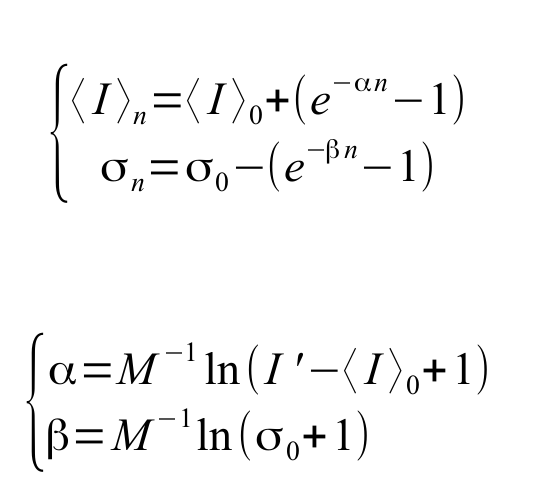

In [227]:
Image('/home/jfiorote/Pictures/Screenshot from 2023-01-17 20-32-19.png', width=300, height=300)

In [228]:
# Initial Parameters

M = 10
n_max = M + 1
n_bins = 11
i_nat = 7
i_0 = 1
sigma2_0 = 0.02 # var
n_step = 1

### Compare with ProteinSystemModel functions

In [229]:
sys_model = ProteinSystemModel(M, i_0, i_nat, sigma2_0)
print(sys_model.expec_ns() == expec_n(M, i_0, i_nat))
print(sys_model.sigma2_ns() == sigma2_n(M, sigma2_0))

True
True


In [230]:
def plot_param_equations(n_seqs, i_0, sigma2_0, i_nat): 
    
    #sigma_0 = math.sqrt(sigma2_0) # desvpad
    
    expecs = expec_n(n_seqs, i_0, i_nat)
    sigmas2 = sigma2_n(n_seqs, sigma2_0)
   
    fig = plt.figure()

    plt.plot(np.arange(n_seqs + 1), expecs, label="expec")
    plt.plot(np.arange(n_seqs + 1), sigmas2, label="vars")
    plt.scatter([0], [0.0052580424], c="grey", label=r'$\sigma ^{2}_{0}$' + f" = 0.005258")
    plt.scatter([1002], [0.0013633716], c="black", label=r'$\sigma ^{2}_{1002}$' + f" = 0.0013633716")
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("value")
    plt.yscale("log")
    plt.title("(EXPECS, SIGMAS) X n")
    plt.savefig("../temp_jupyter_plots/parameters_1bxr.svg")
    plt.show()

In [231]:
# Widgets

i_0_widget = widgets.FloatSlider(value=2.71, min=0.1, max=5, step=0.1, description='i_0:', readout_format='.1f')
i_nat_widget = widgets.FloatSlider(value=10.1, min=0.1, max=19.4, step=0.1, description='i_nat:', readout_format='.1f')
sigma2_0_widget = widgets.FloatSlider(value=0.005, min=0.000001, max=0.2, step=0.0005, description='sigma2_0:', readout_format='.6f')
n_seqs_widget = widgets.IntSlider(value=10004, min=1, max=1004, step=1, description="seqs")

In [232]:
out = widgets.interactive_output(
    plot_param_equations,
    {'n_seqs': n_seqs_widget,
    'i_0':i_0_widget,
    'sigma2_0':sigma2_0_widget,
    'i_nat':i_nat_widget})

ui = widgets.HBox([i_0_widget, i_nat_widget, sigma2_0_widget, n_seqs_widget])


%matplotlib notebook
%matplotlib widget

## Plot Parametric Equations

In [233]:
display(ui, out)

Output()

## Plot Alpha and Beta Values

In [234]:
def plot_alpha_beta():
    n_seqs = 20

    gaps = np.linspace(1, 10, n_seqs)
    seqs = np.arange(n_seqs) + 1
    sigmas2_0 = np.linspace(0.01, 0.05, n_seqs)

    alphas = np.zeros((n_seqs, n_seqs), dtype="float")
    betas = np.zeros((n_seqs, n_seqs), dtype="float")

    for i in range(n_seqs):
        for j in range(n_seqs):
            alphas[i, j] = get_alpha(seqs[i], 0, gaps[j])
            betas[i, j] = get_beta(seqs[i], sigmas2_0[j])


    x_seqs = np.ones((n_seqs, n_seqs), float)
    y_gaps = np.ones((n_seqs, n_seqs), float)
    y_sigmas2_0 = np.ones((n_seqs, n_seqs), float)

    for n in range(n_seqs):
        x_seqs[n] = x_seqs[n] * n
        y_gaps[n] = gaps
        y_sigmas2_0[n] = sigmas2_0

    fig, ax = plt.subplots(2, subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 8)

    ax[0].plot_surface(x_seqs, y_gaps, alphas, cmap='plasma',
                    linewidth=0, antialiased=False, alpha=0.8)
    ax[0].set_xlabel("M")
    ax[0].set_ylabel("gap")
    ax[0].set_zlabel(r'$\alpha$')

    ax[1].plot_surface(x_seqs, y_sigmas2_0, betas, cmap='plasma',
                    linewidth=0, antialiased=False, alpha=0.8)
    ax[1].set_xlabel("M")
    ax[1].set_ylabel(r'$\sigma ^{2}_{0}$')
    ax[1].set_zlabel(r'$\beta$')
    
    plt.savefig("../temp_jupyter_plots/alpha_beta.svg")

    plt.show()

<IPython.core.display.Javascript object>


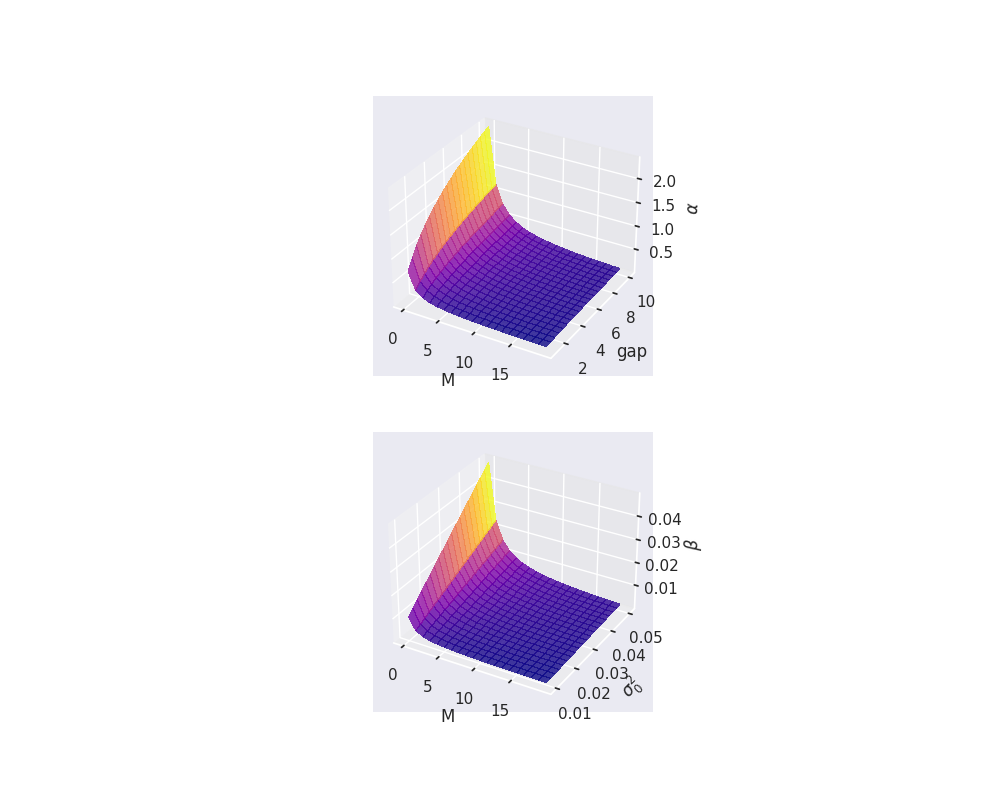

In [235]:
plot_alpha_beta()

## Plot I_n Gap for M Values

<IPython.core.display.Javascript object>


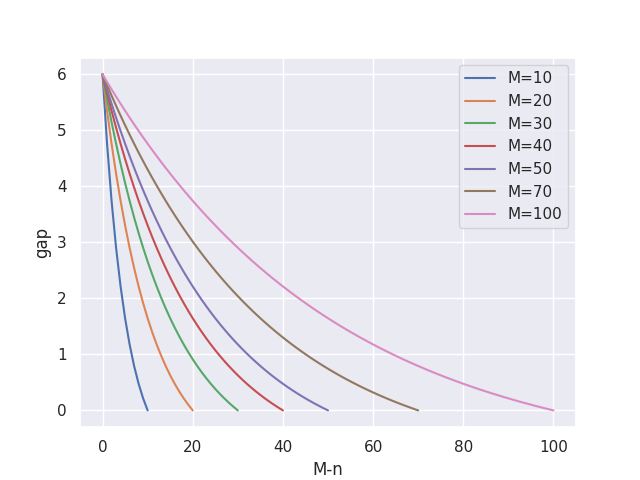

In [236]:
Ms = [10, 20, 30, 40, 50, 70, 100]

fig = plt.figure()

for M in Ms:
    plt.plot(np.flip(np.arange(M + 1)), gap_n(M, 1, 7), label=f"M={M}")

plt.xlabel("M-n")
plt.ylabel("gap")
plt.legend()
plt.show()

## PDFs and Probs Densities

### Define Parameters Values

In [237]:
M = 10
n_max = M + 1
n_bins = 11
i_nat = 5
i_0 = 1
sigma2_0 = 0.4 # var
# sigma_0 = math.sqrt(sigma2_0) # desvpad

### Create Expectation, Var and Data Lists

In [238]:
data = np.linspace(0, i_nat, n_bins + 1) 

expec = expec_n(M, i_0, i_nat)
sigma2 = sigma2_n(M, sigma2_0)

v_func = np.vectorize(lambda x: math.exp(x))
data_s = v_func(data)

bin_center = np.array([(data_s[x] + data_s[x + 1]) / 2 for x in range(n_bins)])
bin_szs = np.array([(data_s[x + 1] - data_s[x]) for x in range(n_bins)])

weights = np.vectorize(poison)
poison_weights = weights(np.arange(n_max)).reshape(-1, 1)


sys_model = ProteinSystemModel(M, i_0, i_nat, sigma2_0)
mdata_s, mbin_center = sys_model.create_data()

print(f"data_s comparision {np.array_equal(mdata_s, data_s)}")
print(f"bins_center comparision {np.array_equal(mbin_center, bin_center)}")
print(f"Poisson Weight comparision {np.array_equal(sys_model.get_poisson_weights(), poison_weights)}")


data_s comparision True
bins_center comparision True
Poisson Weight comparision True


### Calculate pdfs and probs

In [239]:
pdfs = np.zeros((n_max, n_bins), dtype=float)
truncs = np.zeros(n_max, dtype=float)
probs = np.zeros((n_max, n_bins), dtype=float)

for n in np.arange(n_max):

    integral = lognorm_prob(1, math.exp(i_nat), sigma2[n], expec[n]) ##
    trunc = 1 / integral if integral > 0  else 1                     ## trunc log normal
    truncs[n] = trunc                                                ##

    pdfs[n] = lognorm_fit(bin_center, sigma2[n], expec[n])

    vec = []
    for idx in range(n_bins):
        a = data_s[idx]
        b = data_s[idx + 1]
        integ = lognorm_prob(a, b, sigma2[n], expec[n])
        vec.append(integ * trunc)
    probs[n] = vec

pdfs_r = reassessment(pdfs, weight=False)
pdfs_r_poisson = reassessment(pdfs, weight=True)
pdfs_poisson = pdfs * poison_weights

probs_r = reassessment(probs, weight=False)
probs_r_poisson = reassessment(probs, weight=True)
probs_poisson = probs * poison_weights

m_pdfs, m_probs = sys_model.get_prob_bins_lognorm()
poisson_weights = sys_model.get_poisson_weights()

print(f"lognorm pdf comparision {np.array_equal(m_pdfs, pdfs)}")
print(f"lognorm prob comparision {np.array_equal(m_probs, probs)}")
print(f"mixture pdf comparision {np.array_equal(m_pdfs * poisson_weights, pdfs_poisson)}")
print(f"mixture prob comparision {np.array_equal(sys_model.get_probs(), probs_poisson)}")

lognorm pdf comparision True
lognorm prob comparision True
mixture pdf comparision True
mixture prob comparision True


In [240]:
pdfs_arrs = [pdfs, pdfs_poisson, pdfs_r, pdfs_r_poisson]
probs_arrs = [probs, probs_poisson, probs_r, probs_r_poisson]
prob_bins = [get_prob_bin(arr, bin_szs) for arr in pdfs_arrs]

In [241]:
# tran_matrix = get_transitions_matrix(probs_poisson)
# init_state = np.unravel_index(np.argmax(probs_poisson, axis=None), probs_poisson.shape)
# best_path = get_best_path(tran_matrix[0], tran_matrix[1], len(data) - 1, list(init_state))

### Sum Probs

In [242]:
print("Probs - ", np.sum(m_probs), 
      "\nPoisson Probs - ", np.sum(m_probs * poisson_weights),
      "\nReass Probs - ", np.sum(probs_arrs[2]),
      "\nReass Poisson Probs - ", np.sum(probs_arrs[3]))

Probs -  10.999999999999998 
Poisson Probs -  0.9999999899522334 
Reass Probs -  10.888888888890001 
Reass Poisson Probs -  0.9999999427080335


### Plot pdfs and probs

<IPython.core.display.Javascript object>


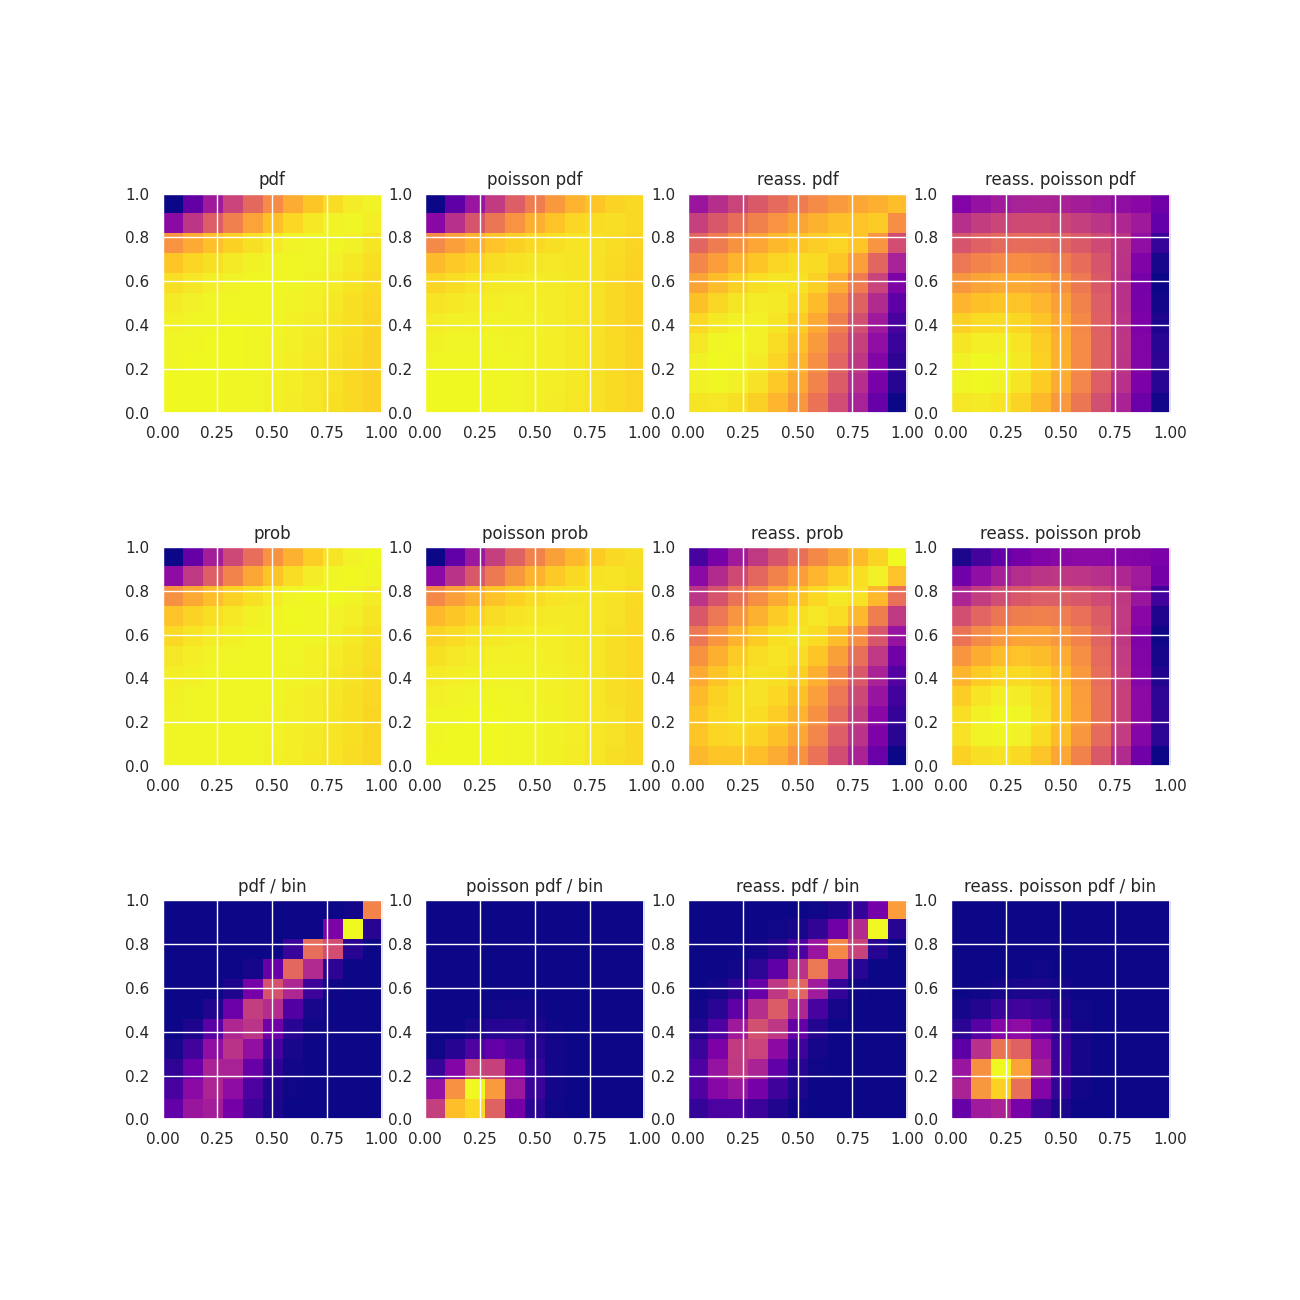

In [243]:
fig, axs  = plt.subplots(3, 4)
colors = "plasma"
fig.set_size_inches(13, 13)

titles = ["pdf", "poisson pdf", "reass. pdf", "reass. poisson pdf"]
for i in range(4):
    z_prob = np.log10(pdfs_arrs[i][::-1])
    c = axs[0, i].imshow(z_prob, extent=[0, 1, 0, 1], cmap=colors, interpolation='nearest')
    axs[0, i].set_title(titles[i])


titles = ["prob", "poisson prob", "reass. prob", "reass. poisson prob"]
for i in range(4):
    z_prob = np.log(probs_arrs[i][::-1])
    c = axs[1, i].imshow(z_prob, extent=[0, 1, 0, 1], cmap=colors, interpolation='nearest')
    axs[1, i].set_title(titles[i])

titles = ["pdf / bin", "poisson pdf / bin", "reass. pdf / bin", "reass. poisson pdf / bin"]
for i in range(4):
    z_prob = prob_bins[i][::-1]
    c = axs[2, i].imshow(z_prob, extent=[0, 1, 0, 1], cmap=colors, interpolation='nearest')
    axs[2, i].set_title(titles[i])



plt.savefig("../temp_jupyter_plots/densities.svg")
plt.show()

<IPython.core.display.Javascript object>


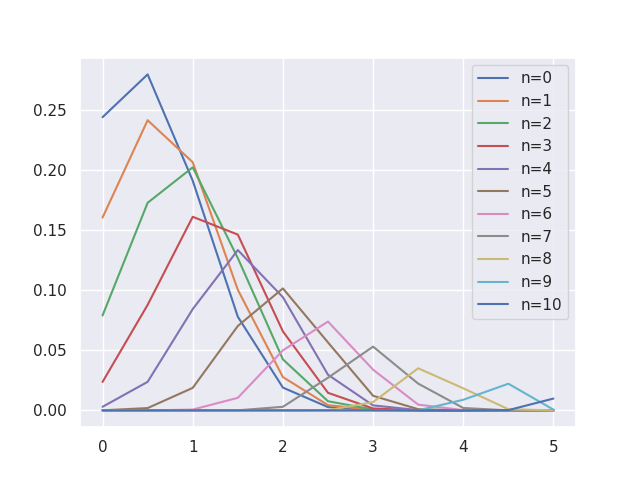

[2.43799610e-01 2.79369943e-01 1.90985630e-01 7.78925713e-02
 1.89524661e-02 2.75112139e-03 2.38247370e-04 1.23089446e-05
 3.79391726e-07 6.97636559e-09 7.65323318e-11]


In [244]:
fig = plt.figure()

x = np.linspace(0, i_nat, n_bins)
print(pdfs_arrs[0][0])
for n, curve in enumerate(pdfs_arrs[0]):
    plt.plot(x, curve, label=f"n={n}")
    
plt.legend()

plt.savefig("../temp_jupyter_plots/lognorm_curves.svg")

[[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


<IPython.core.display.Javascript object>


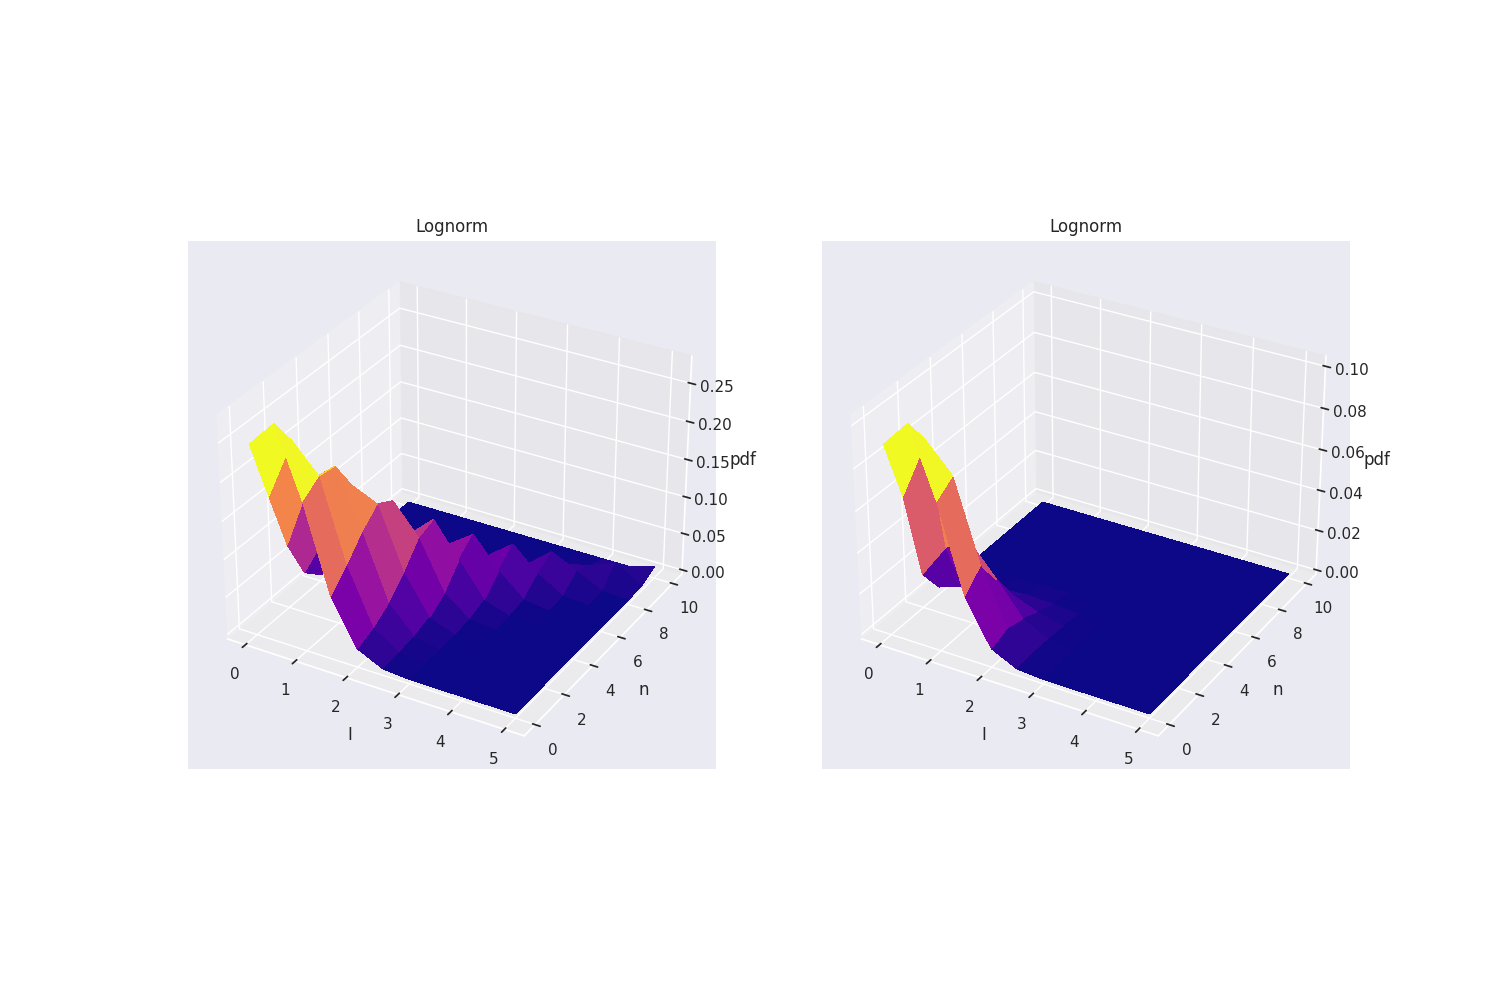

In [245]:

x = np.zeros((n_max, n_max), float)
y = np.ones((n_max, n_max), float)

for n in range(n_max):
    y[n] = [n_max - (n + 1)] * n_max
    x[n] = np.linspace(0, i_nat, n_bins)
print(y)
    
fig = plt.figure()
fig.set_size_inches(15, 10)

ax = fig.add_subplot(1, 2, 1, projection='3d')

z_prob = pdfs_arrs[0][::-1]
ax.plot_surface(x, y,  z_prob, cmap=colors,
                linewidth=0, antialiased=False)
ax.set_xlabel("I")
ax.set_ylabel("n")
ax.set_zlabel("pdf")
ax.set_title("Lognorm")

ax = fig.add_subplot(1, 2, 2, projection='3d')

z_prob = pdfs_arrs[1][::-1]
ax.plot_surface(x, y,  z_prob, cmap=colors,
                linewidth=0, antialiased=False)
ax.set_xlabel("I")
ax.set_ylabel("n")
ax.set_zlabel("pdf")
ax.set_title("Lognorm")

plt.savefig("../temp_jupyter_plots/3d_pdf.svg")

## Max Probability Trajs

### Functions

In [246]:
M = 10
n_max = M + 1
n_bins = M + 1
i_nat = 5
i_0 = 1
sigma2_0 = 0.02 # var

In [259]:
def alt_get_single_model(i_0, i_nat, sigma2_0, M=10, n_bins=11, n_step=1):
    
    n_max = M + 1
    data = np.linspace(i_0, i_nat, n_bins + 1)

    expec = expec_n(M, i_0, i_nat)
    sigma2 = sigma2_n(M, sigma2_0)

    v_func = np.vectorize(lambda x: math.exp(x))
    data_s = v_func(data)

    bin_center = np.array([(data_s[x] + data_s[x + 1]) / 2 for x in range(n_bins)])
    bin_szs = np.array([(data_s[x + 1] - data_s[x]) for x in range(n_bins)])

    weights = np.vectorize(poison)
    poison_weights = weights(np.arange(n_max)).reshape(-1, 1)

    ##################################################################################

    pdfs = np.zeros((n_max, n_bins), dtype=float)
    truncs = np.zeros(n_max, dtype=float)
    probs = np.zeros((n_max, n_bins), dtype=float)

    for n in np.arange(n_max):

        integral = lognorm_prob(1, math.exp(i_nat), sigma2[n], expec[n])  ##
        #trunc = 1 / integral if integral != 0 else 1                     ## trunc log normal
        trunc = 1 / integral if integral > 0 else 1 
        truncs[n] = trunc                                                ##
        
        pdfs[n] = lognorm_fit(bin_center, sigma2[n], expec[n])

        
        vec = []
        for idx in range(n_bins):
            a = data_s[idx]
            b = data_s[idx + 1]
            integ = lognorm_prob(a, b, sigma2[n], expec[n])
            vec.append(integ * trunc)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
        probs[n] = vec

    probs_poisson = probs * poison_weights
    #probs_r_poisson = reassessment(probs, weight=True)

    
    ##################################################################################
    target = probs_poisson
    ##################################################################################
    init_state = np.unravel_index(np.argmax(target[0], axis=None), target.shape)
    tran_matrix = get_transitions_matrix(target, n_step=n_step)

#    best_path = get_best_path(tran_matrix[0], tran_matrix[1], len(data) - 1, list(init_state))
    
    best_path = get_best_path(tran_matrix[0], tran_matrix[1], len(data) - 1, [0, 0])
    tp_rate = best_path[0][-1][0]
    
    return tp_rate / M, best_path[0], target

In [260]:

ga_model = GAModel()

tp, best_path, probs = alt_get_single_model(i_0, i_nat, sigma2_0, M, n_bins, n_step=1)
sys_model = ProteinSystemModel(M, i_0, i_nat, sigma2_0)

print(np.array_equal(sys_model.get_probs(), probs))


False


### Transitions Array n Product

<IPython.core.display.Javascript object>


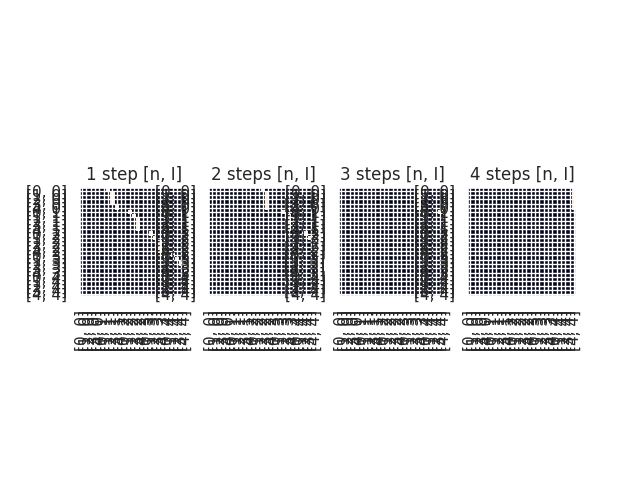

In [261]:
n_bins = 5
M = 4

res = alt_get_single_model(i_0, i_nat, sigma2_0, M, n_bins)

tran_matrix = get_transitions_matrix(res[2])

idxs = [str(x) for x in tran_matrix[1]]

res = tran_matrix[0]

fig, axs  = plt.subplots(1, n_bins - 1)

axs[0].imshow(res)
axs[0].set_title(f"1 step [n, I]")
axs[0].set_xticks(list(range(len(idxs))))
axs[0].set_xticklabels(idxs, rotation='vertical')
axs[0].set_yticks(list(range(len(idxs))))
axs[0].set_yticklabels(idxs)


for i in range(n_bins - 2):
    res = np.dot(res, tran_matrix[0])
    axs[i + 1].imshow(res)
    axs[i + 1].set_title(f"{i + 2} steps [n, I]")
    axs[i + 1].set_xticks(list(range(len(idxs))))
    axs[i + 1].set_xticklabels(idxs, rotation='vertical')
    axs[i + 1].set_yticks(list(range(len(idxs))))
    axs[i + 1].set_yticklabels(idxs)

plt.show()


In [262]:
def plot_best_paths(i_0, bins, sigma2_0):
    arr = []
    seqs = [4, 8, 16, 32, 64]
    
    #sigma_0 = math.sqrt(sigma2_0)
    
    for seq in seqs:
        arr.append(alt_get_single_model(i_0, 7, sigma2_0, seq, n_bins=seq + 1)[1])
        
    fig = plt.figure()
    for idx, i in enumerate(arr):
        x_axis = [x[1] / bins for x in i]
        y_axis = [y[0] / seqs[idx] for y in i]
        plt.plot(x_axis, y_axis, label=f"M: {seqs[idx]}")
    
    plt.xlabel("I")
    plt.ylabel("n")
    plt.legend()
    plt.show()

In [263]:
i_0_widget = widgets.FloatSlider(value=2, min=0.001, max=6, step=0.5, description='I0', readout_format='.3f')
bins_widget = widgets.IntSlider(value=10, min=1, max=50, step=1, description='BINS')
sigma2_0_widget = widgets.FloatSlider(value=0.015, min=0.0015, max=0.5, step=0.001, description=r'$\sigma ^{2} _{0}$', readout_format='.3f')

In [264]:
out = widgets.interactive_output(
    plot_best_paths,
    {'i_0': i_0_widget,
     'bins': bins_widget,
    'sigma2_0':sigma2_0_widget})

ui = widgets.HBox([i_0_widget, bins_widget, sigma2_0_widget])

### Plot Trajs

In [265]:
display(ui, out)

Output()

## TP Rate

### Functions

In [266]:
def get_tp_alt(sigma2_0):
    
    #sigma_0 = math.sqrt(sigma2_0)
    
    fig, axs = plt.subplots(5, 1, figsize=(20,30))
    
    for idx, i in enumerate([10, 20, 30, 40, 50]):

        val_dict = {}

        i0s = [1, 2, 3, 4]
        seqs = np.arange(1, 51)

        for i0 in i0s:
            tps = [alt_get_single_model(i0, i_nat, sigma2_0, seq, n_bins=i)[0] for seq in seqs]
            val_dict[str(i0)] = [list(seqs), tps]
            axs[idx].plot(seqs, tps, label=f"i0 = {i0}")
            axs[idx].set_xlabel("seqs")
            axs[idx].set_ylabel(f"tp rate - bins={i}")
    
    plt.legend()

        #f_save = open(f"exp_values_var_{sigma_0}.py", 'w')
        #f_save.write(f"exp_values = {val_dict}")
        #f_save.close()

    plt.show()

In [267]:

M = 10
n_max = M + 1
n_bins = 11
i_nat = 7
i_0 = 2
sigma2_0 = 0.02
#sigma_0 = math.sqrt(sigma2_0)
n_step = 1

<IPython.core.display.Javascript object>


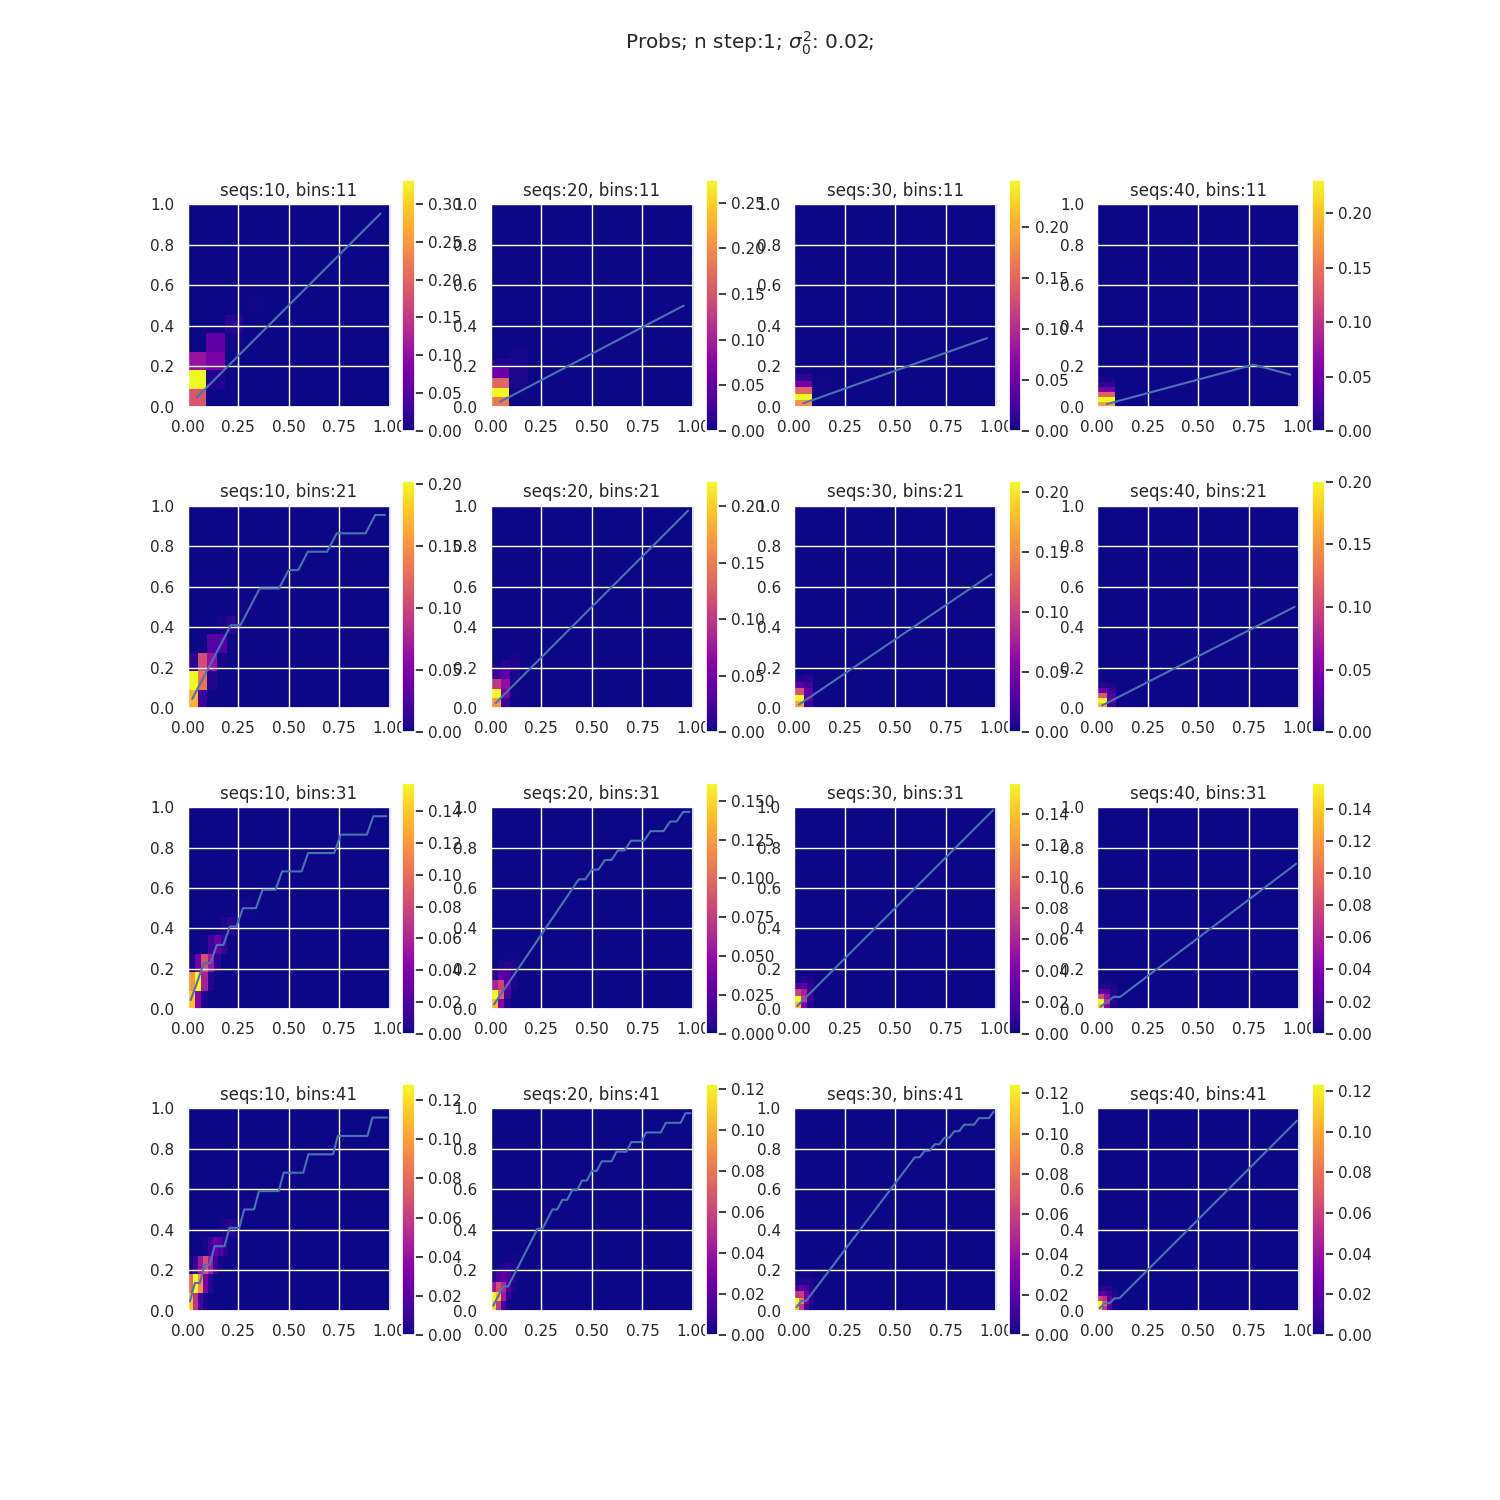

FileNotFoundError: [Errno 2] No such file or directory: 'temp_jupyter_plots/trajs.svg'

In [268]:
fig, axs  = plt.subplots(4, 4, figsize=(20, 28))
colors = "plasma"
fig.set_size_inches(15, 15)

seqs_bins = [10, 20, 30, 40]

for idx1, b in enumerate(seqs_bins):
    b = b + 1
    for idx2, s in enumerate(seqs_bins):

        _, path, prob_arr = alt_get_single_model(i_0, i_nat, sigma2_0, s, b, n_step=n_step)
        z_prob = prob_arr[::-1]
        c = axs[idx1, idx2].imshow(z_prob, extent=[0, 1, 0, 1], cmap=colors, interpolation='nearest')
        x = [(x[1] / b) + 0.5 * 1 / b for x in path]
        y = [(x[0] / (s + 1)) + 0.5 * 1 / (s + 1) for x in path]
        
        ax=axs[idx1, idx2]
        fig.colorbar(c, ax=ax)
        #c.set_clim(0, 0.18) # cbar range
        axs[idx1, idx2].plot(x, y)
        axs[idx1, idx2].set_title(f"seqs:{s}, bins:{b}")
        
        
plt.suptitle(f"Probs; n step:{n_step}; " + r"$\sigma _{0} ^{2}$" + f": {sigma2_0};")
plt.savefig("temp_jupyter_plots/trajs.svg")
plt.show()

In [269]:
M = 10
n_max = M + 1
n_bins = 11
i_nat = 7
i_0s = [2, 3, 4, 5] 
sigmas2_0 = [0.02, 0.05, 0.1, 0.2]
#sigma_0s = np.sqrt(sigmas2_0)
n_step = 1

<IPython.core.display.Javascript object>


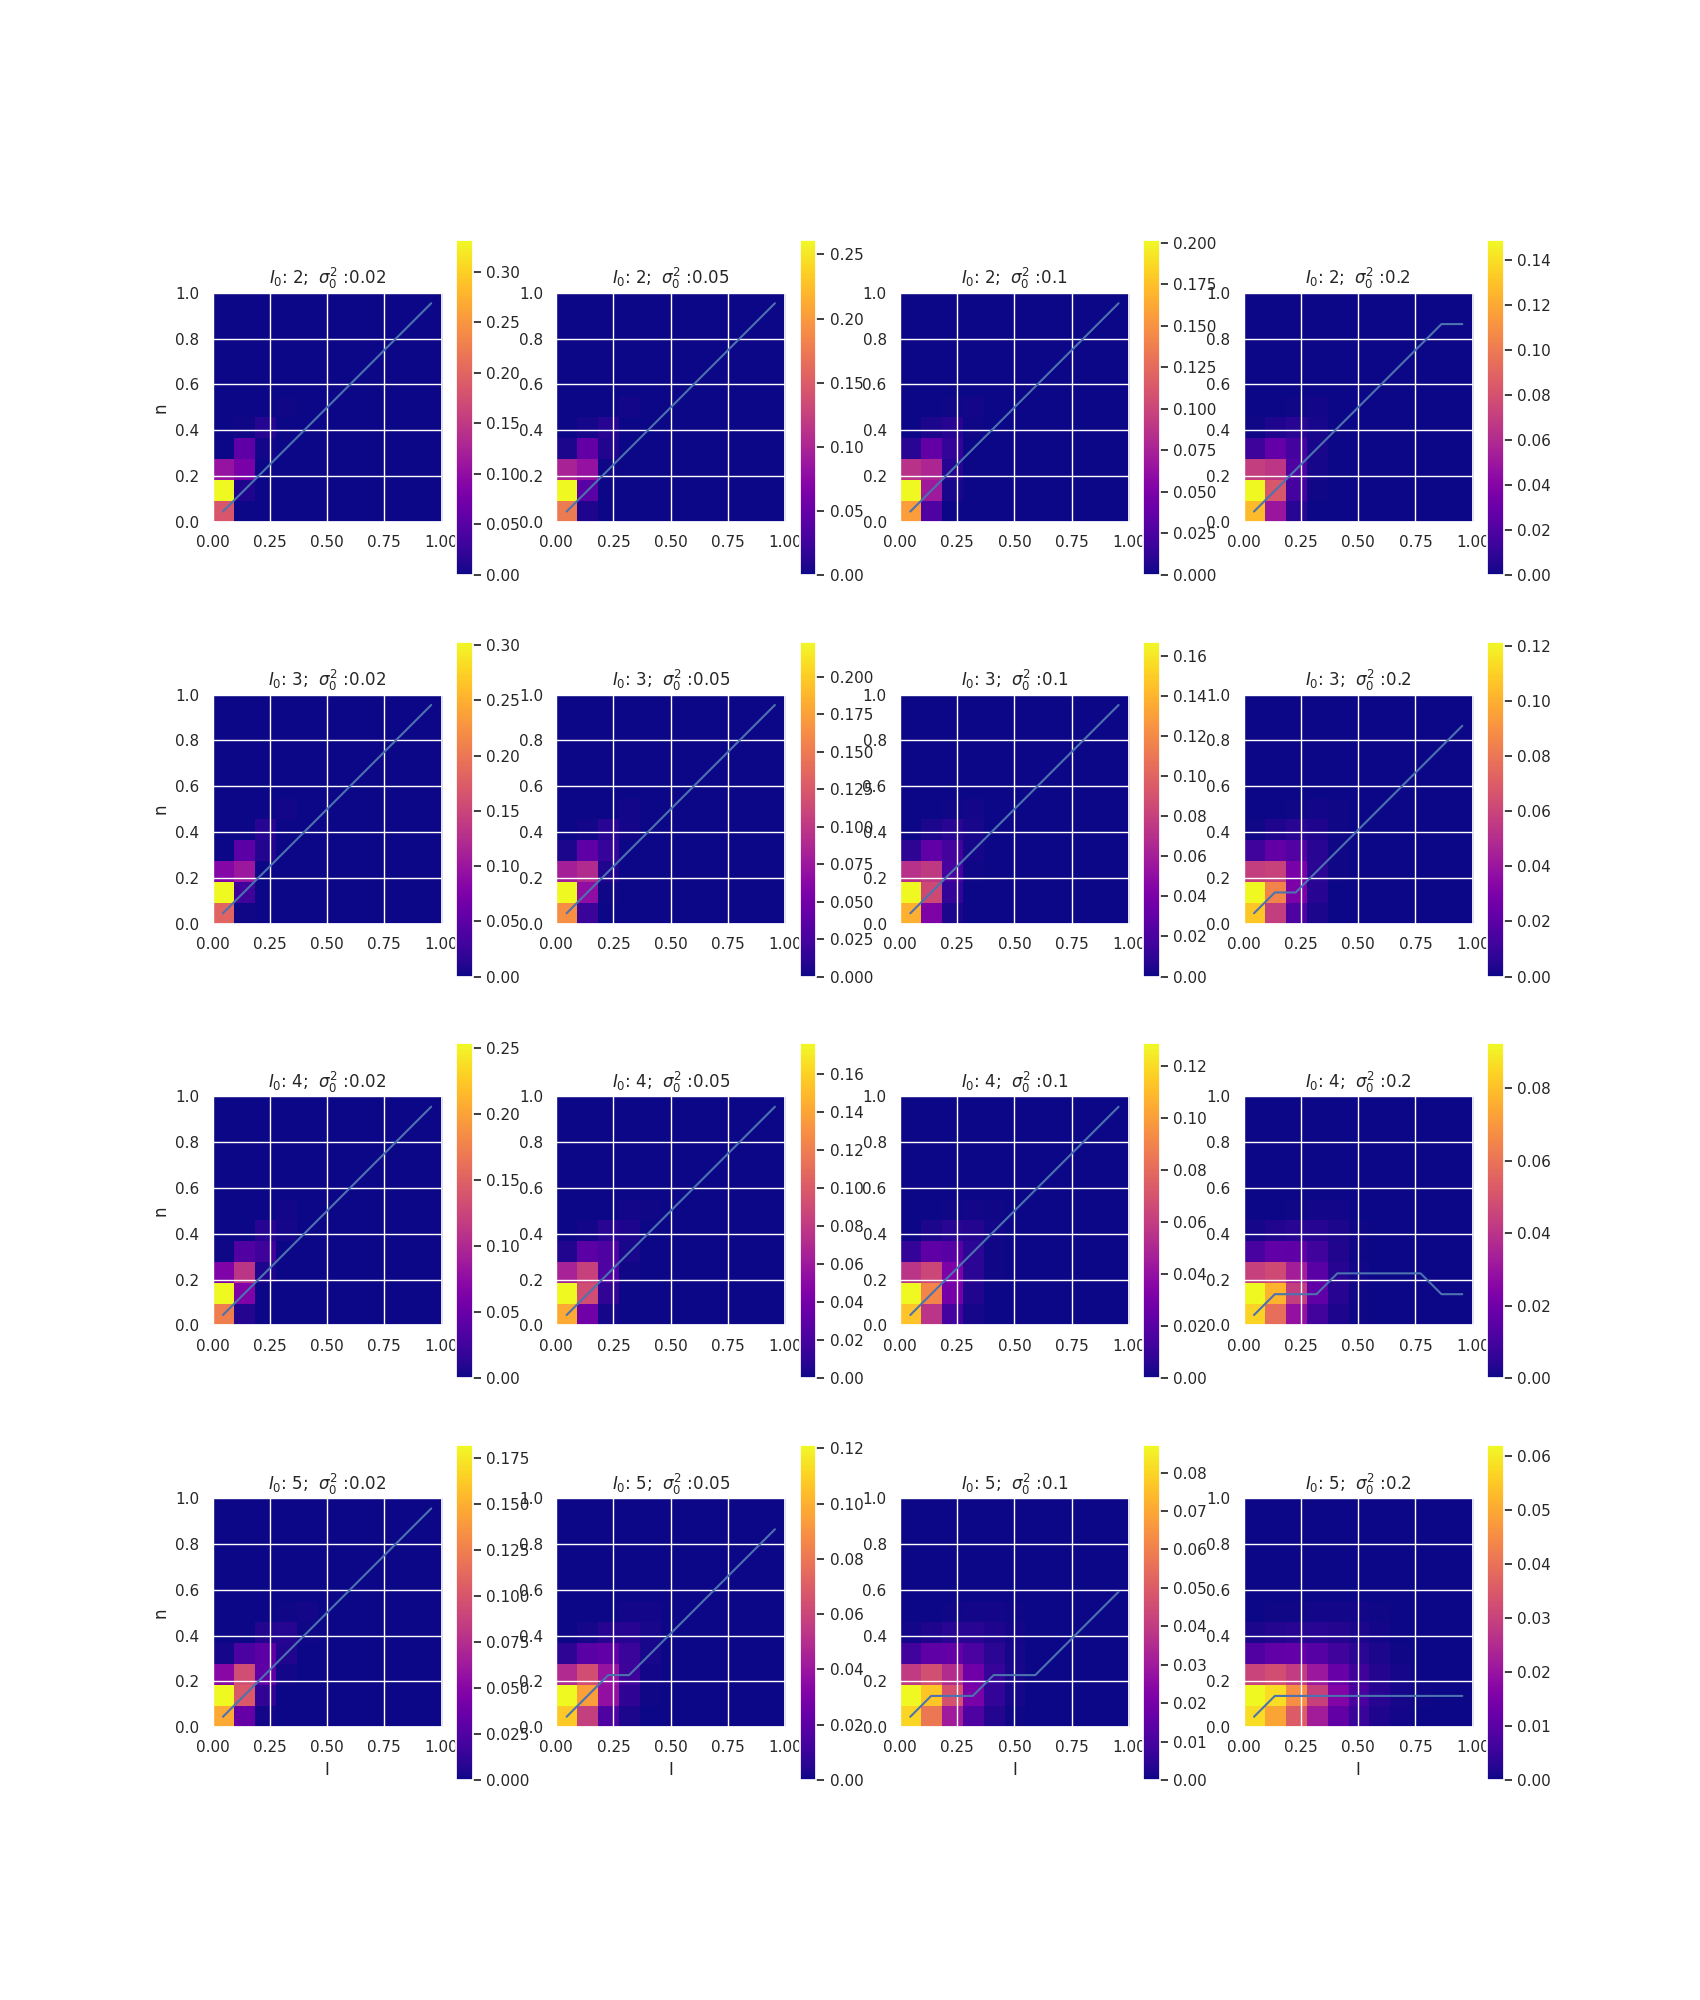

[1.83699046e-001 2.40674411e-004 2.37442037e-011 9.74026426e-023
 1.45478378e-038 7.54227060e-059 1.32740552e-083 7.83478381e-113
 1.53951917e-146 1.00232129e-184 2.15512147e-227]
[1.76200671e-01 7.73023677e-03 8.81300548e-06 1.97104869e-10
 7.82138750e-17 5.28299579e-25 5.95120285e-35 1.10529047e-46
 3.36075488e-60 1.66524544e-75 1.34033606e-92]
[1.56237540e-01 2.69585381e-02 7.40669733e-04 2.97156449e-06
 1.64534924e-09 1.21827590e-13 1.18517994e-18 1.49912070e-24
 2.44928351e-31 5.14613427e-39 1.38620895e-47]
[1.27021621e-01 4.91797321e-02 7.31700251e-03 4.13264196e-04
 8.74452849e-06 6.85111123e-08 1.96899501e-10 2.06130643e-13
 7.82034659e-17 1.07119595e-20 5.28292264e-25]
[1.82076075e-001 1.86359581e-003 4.98420836e-008 2.24475628e-015
 1.51162067e-025 1.45478378e-038 1.95827468e-054 3.64340315e-073
 9.30168676e-095 3.24332383e-119 1.53951917e-146]
[1.64828297e-01 1.89009784e-02 2.10248427e-04 1.96416250e-07
 1.42979497e-11 7.82138439e-17 3.15486946e-23 9.28186230e-31
 1.97832549

FileNotFoundError: [Errno 2] No such file or directory: 'temp_jupyter_plots/trajs_i0_s0.svg'

In [270]:
fig, axs = plt.subplots(4, 4, figsize=(17, 20))

for idx1, i0 in enumerate(i_0s):
    for idx2, s0 in enumerate(sigmas2_0):

        _, path, prob_arr = alt_get_single_model(i0, i_nat, s0, M, n_bins, n_step=n_step)
        z_prob = prob_arr[::-1]
        print(z_prob[-1])
        c = axs[idx1, idx2].imshow(z_prob, extent=[0, 1, 0, 1], cmap=colors, interpolation='nearest')
        x = [(x[1] / n_bins) + 0.5 * 1 / n_bins for x in path]
        y = [(x[0] / (n_max)) + 0.5 * 1 / (n_max) for x in path]
        ax=axs[idx1, idx2]
        fig.colorbar(c, ax=ax)
        #c.set_clim(0, 0.18) # cbar range
        axs[idx1, idx2].plot(x, y)
        axs[idx1, idx2].set_title("".join([r'$I _{0}$', f": {i0};  ", r'$\sigma _{0} ^{2}$', f" :{s0}"]))
        
        if idx2 == 0:
            axs[idx1, idx2].set_ylabel("n")
        if idx1 == 3:
            axs[idx1, idx2].set_xlabel("I")
            
        
        
#plt.suptitle(f"Probs; n step: {n_step}; var: {sigma_0};")
plt.savefig("temp_jupyter_plots/trajs_i0_s0.svg")
plt.show()

### Plot Tp Rate for M

### Alpha x TP Rate dependence

In [ ]:
seqs = [10, 20, 40, 60, 80, 100, 120, 140, 160]
i0s = np.arange(0.001, (i_nat - 1), 0.3)

sigmas2_0 = [0.014, 0.02, 0.030,  0.04, 0.05]
#sigmas_0 = np.sqrt(sigmas2_0)

n_step = 1

fig, axs = plt.subplots(2, 3)

for idx, sigma2_0 in enumerate(sigmas2_0):
    row = int(idx / 3)
    col = idx % 3
    for seq in seqs:
        arr = np.load(f"alphas_data/alphaxtp_m{seq}_sigma{sigmas2_0[idx]}.npy")
    
        alphas = arr[0]
        tps = arr[1]

        order_x = np.argsort(alphas)
        new_alphas = [alphas[x] for x in order_x]
        new_tps = [tps[x] for x in order_x]

        clear_tps = []
        clear_alphas = []
        for idx_tp, tp in enumerate(new_tps):
            if idx_tp == 0: 
                clear_tps.append(tp)
                clear_alphas.append(new_alphas[idx_tp])
            elif tp < clear_tps[-1]:
                pass
            else:
                clear_tps.append(tp)
                clear_alphas.append(new_alphas[idx_tp])

        
#         alphas = []
#         tps = []
#         for i0 in i0s:            
#             alphas.append(get_alpha(seq, i0, i_nat))
#             tps.append(alt_get_single_model(i0, i_nat, sigma2_0, M=seq, n_bins=seq + 1, n_step=n_step)[0])
        axs[row, col].plot(clear_alphas, clear_tps, label=f"M={seq}")
        np.save(f"alphas_data/clear_alphaxtp_m{seq}_sigma{sigmas2_0[idx]}", [clear_alphas, clear_tps])
    axs[row, col].set_title("".join([r'$\sigma^{2} _{0}$',f" :{sigma2}; gap max={i_nat - i0s[0]}"]))
    axs[row, col].set_xlabel(r'$\alpha$')
    axs[row, col].set_ylabel("tp")
    
plt.legend()
plt.savefig("temp_jupyter_plots/convergence.svg")
plt.show()


### GAP x TP Rate dependence

In [ ]:
# i_nat = 7
# seqs = [10, 20, 40, 60, 80, 100, 120, 140, 160]
# i0s = np.arange(0.001, (i_nat - 1), 0.2)

# sigmas_0 = [0.005]#, 0.01, 0.02, 0.03, 0.04, 0.05]
# n_step = 1


# fig, axs = plt.subplots(2, 3)

# for idx, sigma_0 in enumerate(sigmas_0):
#     row = int(idx / 3)
#     col = idx % 3
#     for seq in seqs:
#         tps = []
#         for idx, i0 in enumerate(i0s):
#             tps.append(alt_get_single_model(i0, i_nat, sigma_0, M=seq, n_bins=seq, n_step=n_step)[0])
#         np.save(f"i0xtp_m{seq}_sigma{sigma_0}", [i0s, tps])
#         axs[row, col].plot(i0s, tps, label=f"M={seq}")

#     axs[row, col].set_title(f"sigma0={sigma_0}; step max={n_step}; i_nat = 6, bins=M")
#     axs[row, col].set_xlabel("i0")
#     axs[row, col].set_ylabel("tp")
# plt.legend()
# plt.show()